In [1]:
# Essential imports for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Import data cleaning function and visualization config
from data_cleaning import load_and_clean_data
from viz_config import BASE_ACCENT, ALT_ACCENT, ALT_ACCENT_2, BASE_PALETTE, LINE_PALETTE, CATEGORY_PALETTE

# Set pandas display options (optional - already set in data_cleaning.py)
pd.set_option('display.max_columns', None)

# Load and clean data
# Note: seaborn theme is automatically configured when importing viz_config
query_df = load_and_clean_data(verbose=True)

Performance data shape: (10174314, 5)
Performance columns: ['QUERY_ID', 'TOTAL_TIME', 'EXECUTION_TIME', 'QUEUEING_TIME', 'BYTES_SPILLED_TO_REMOTE']
----------------------------------------
Objects data shape: (10174314, 9)
Objects columns: ['QUERY_ID', 'QUERY_START_TIME', 'DATABASE_ID', 'WAREHOUSE_NAME', 'QUERY_TYPE', 'WAREHOUSE_SIZE', 'HUMAN_USER', 'SCHEMA_INDEX', 'SCHEMA_NAME']
Date range: 2021-03-30 22:19:18.438000000 to 2021-06-28 22:02:52.319000000

Cleaning performance data...
Number of perf rows: 10174314
Number of unique queries: 4211224
Duplicate queries: 5963090

Cleaning objects data...
Shape of objects_df: (10174314, 9)
Total number of queries: 4211224
Types of Databases: [ 6. 36. 15. 33. nan  4.]
Types of Warehouses: ['BI TOOL' 'SCHEDULER' 'ANALYSTS']
Types of Query Types: ['SELECT' 'INSERT' 'CREATE_TABLE_AS_SELECT' 'CREATE_VIEW' 'UPDATE' 'MERGE'
 'DELETE' 'SET' 'UNKNOWN' 'CREATE_TABLE' 'UNLOAD' 'RECLUSTER']
Types of Warehouse Sizes: ['Small' 'X-Small' nan 'Medium']
Types 

/Users/megpatakota/Desktop/wise_takehome/data_cleaning.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_df["QUERY_ID"] = objects_df["QUERY_ID"].astype(str)



Final query_df shape: (4211224, 24)
Final query_df columns: ['QUERY_ID', 'TOTAL_TIME', 'EXECUTION_TIME', 'QUEUEING_TIME', 'BYTES_SPILLED_TO_REMOTE', 'TOTAL_TIME_MS', 'EXECUTION_TIME_MS', 'QUEUEING_TIME_MS', 'TOTAL_TIME_MIN', 'EXECUTION_TIME_MIN', 'QUEUEING_TIME_MIN', 'EXECUTION_AND_QUEUEING_TIME_MIN', 'TIME_DELAY_MIN', 'QUERY_START_TIME', 'DATABASE_ID', 'WAREHOUSE_NAME', 'QUERY_TYPE', 'WAREHOUSE_SIZE', 'HUMAN_USER', 'SCHEMA_INDEX', 'SCHEMA_NAME', 'QUERY_DATE', 'QUERY_HOUR', 'QUERY_WEEKDAY']


Percentile Summary for TOTAL_TIME_MIN:
Percentile  Total Time (min)
       P25              0.01
       P50              0.06
       P75              0.58
       P90              1.86
       P95              2.99
       P99              7.82

Min: 0.00 min
Max: 328.23 min
Mean: 0.68 min
Median: 0.06 min


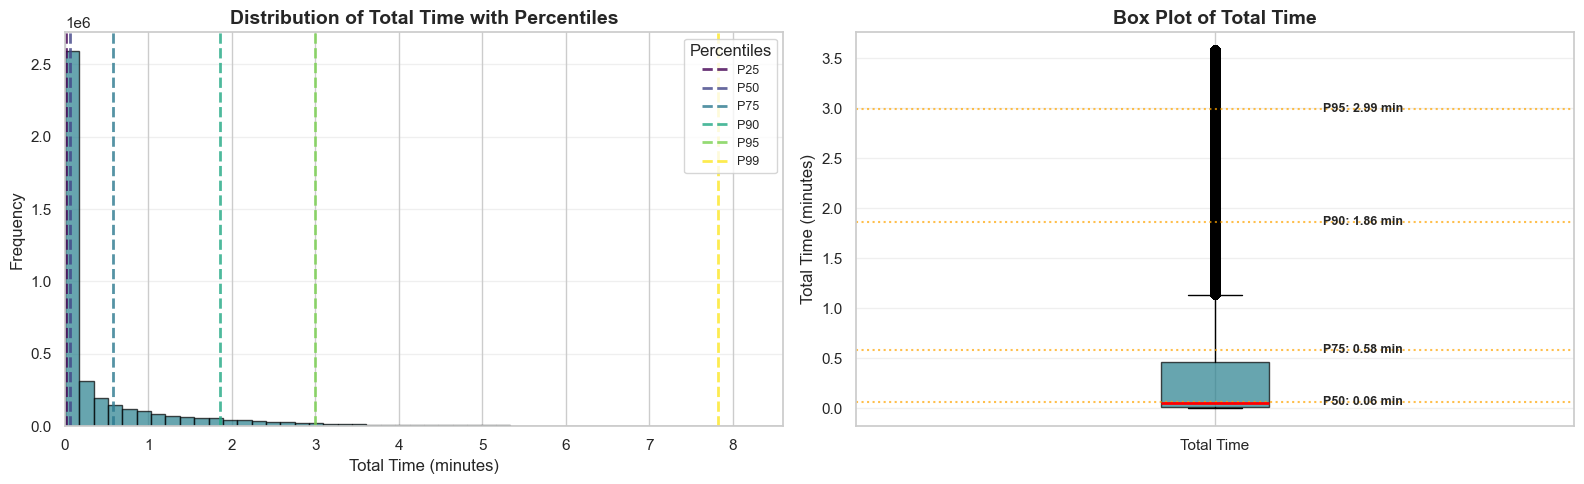

In [35]:
# plot total_time with percentiles and quantiles

# Calculate key percentiles and quantiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
percentile_values = {f'P{int(p*100)}': query_df['TOTAL_TIME_MIN'].quantile(p) for p in percentiles}

# Create a summary DataFrame
percentile_df = pd.DataFrame([
    {'Percentile': k, 'Total Time (min)': v} 
    for k, v in percentile_values.items()
])

print("Percentile Summary for TOTAL_TIME_MIN:")
print(percentile_df.to_string(index=False))
print(f"\nMin: {query_df['TOTAL_TIME_MIN'].min():.2f} min")
print(f"Max: {query_df['TOTAL_TIME_MIN'].max():.2f} min")
print(f"Mean: {query_df['TOTAL_TIME_MIN'].mean():.2f} min")
print(f"Median: {query_df['TOTAL_TIME_MIN'].median():.2f} min")

# Create visualization with histogram and percentile lines
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Histogram with percentile lines
ax1 = axes[0]
# Filter outliers for better visualization (show up to P99)
max_time = percentile_values['P99'] * 1.1
filtered_data = query_df[query_df['TOTAL_TIME_MIN'] <= max_time]['TOTAL_TIME_MIN']

ax1.hist(filtered_data, bins=50, color=ALT_ACCENT, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Total Time (minutes)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Total Time with Percentiles', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add vertical lines for percentiles
colors = plt.cm.viridis(np.linspace(0, 1, len(percentile_values)))
for i, (label, value) in enumerate(percentile_values.items()):
    ax1.axvline(value, color=colors[i], linestyle='--', linewidth=2, label=label, alpha=0.8)
ax1.legend(title='Percentiles', loc='upper right', fontsize=9)
ax1.set_xlim(0, max_time)

# Right plot: Box plot with percentile annotations
ax2 = axes[1]
# Use a filtered dataset for boxplot (up to P95 for better visibility)
boxplot_data = query_df[query_df['TOTAL_TIME_MIN'] <= percentile_values['P95'] * 1.2]['TOTAL_TIME_MIN']
bp = ax2.boxplot([boxplot_data], vert=True, patch_artist=True, 
                 boxprops=dict(facecolor=ALT_ACCENT, alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))

ax2.set_ylabel('Total Time (minutes)', fontsize=12)
ax2.set_title('Box Plot of Total Time', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Total Time'])
ax2.grid(axis='y', alpha=0.3)

# Add percentile annotations
y_positions = [percentile_values['P50'], percentile_values['P75'], percentile_values['P90'], percentile_values['P95']]
labels = ['P50', 'P75', 'P90', 'P95']
for y_pos, label in zip(y_positions, labels):
    if y_pos <= boxplot_data.max():
        ax2.axhline(y_pos, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
        ax2.text(1.15, y_pos, f'{label}: {y_pos:.2f} min', 
                va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


### plot_percentile_breakdown

,percentile,threshold_min,queries_at_or_below,queries_above,percentile_pct,xtick
0,0.25,0.01,1381550,2829674,25,P25\n(0.01 min)
1,0.50,0.06,2163444,2047780,50,P50\n(0.06 min)
2,0.75,0.58,3163536,1047688,75,P75\n(0.58 min)
3,0.80,0.86,3371417,839807,80,P80\n(0.86 min)
4,0.85,1.27,3582430,628794,85,P85\n(1.27 min)
5,0.90,1.86,3790626,420598,90,P90\n(1.86 min)
6,0.95,2.99,4000710,210514,95,P95\n(2.99 min)
7,0.99,7.82,4169185,42039,99,P99\n(7.82 min)


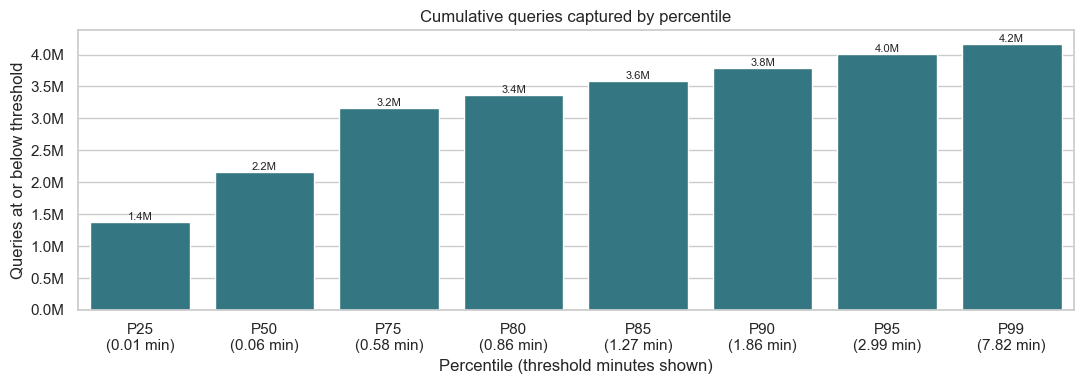

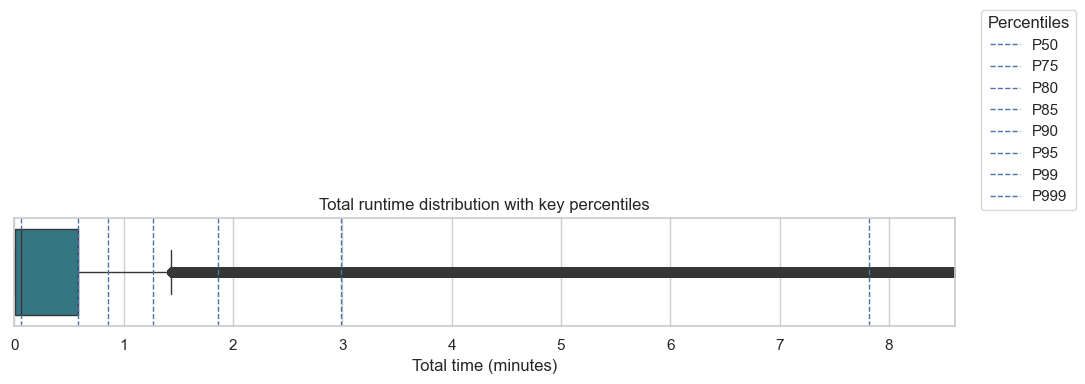

In [2]:
def plot_percentile_breakdown(query_df, time_col):
    percentiles = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    percentile_breakdown = pd.DataFrame({
        "percentile": percentiles,
        "threshold_min": [query_df[time_col].quantile(p) for p in percentiles],
    })
    percentile_breakdown["threshold_min"] = percentile_breakdown["threshold_min"].round(2)
    percentile_breakdown["queries_at_or_below"] = percentile_breakdown["threshold_min"].apply(
        lambda t: (query_df[time_col] <= t).sum()
    )
    percentile_breakdown["queries_above"] = query_df.shape[0] - percentile_breakdown["queries_at_or_below"]
    percentile_breakdown["percentile_pct"] = (percentile_breakdown["percentile"] * 100).astype(int)
    percentile_breakdown["xtick"] = percentile_breakdown.apply(
        lambda row: f"P{int(row['percentile'] * 100)}\n({row['threshold_min']:.2f} min)", axis=1
    )

    ordered_percentiles = percentile_breakdown.sort_values("percentile_pct").reset_index(drop=True)
    display(ordered_percentiles)

    plt.figure(figsize=(11, 4))
    ax_bar = sns.barplot(
        data=ordered_percentiles,
        x="xtick",
        y="queries_at_or_below",
        color=ALT_ACCENT,
        order=ordered_percentiles["xtick"]
    )
    ax_bar.set_xlabel("Percentile (threshold minutes shown)")
    ax_bar.set_ylabel("Queries at or below threshold")
    ax_bar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))
    for patch, (_, row) in zip(ax_bar.patches, ordered_percentiles.iterrows()):
        ax_bar.annotate(
            f"{row['queries_at_or_below'] / 1_000_000:.1f}M",
            (patch.get_x() + patch.get_width() / 2, patch.get_height()),
            ha="center",
            va="bottom",
            fontsize=8,
        )
    plt.title("Cumulative queries captured by percentile")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 4))
    ax = sns.boxplot(data=query_df, x=time_col, color=ALT_ACCENT)
    percentile_lines = {
        "P50": query_df[time_col].quantile(0.5),
        "P75": query_df[time_col].quantile(0.75),
        "P80": query_df[time_col].quantile(0.8),
        "P85": query_df[time_col].quantile(0.85),
        "P90": query_df[time_col].quantile(0.9),
        "P95": query_df[time_col].quantile(0.95),
        "P99": query_df[time_col].quantile(0.99),
        "P999": query_df[time_col].quantile(0.999),
    }
    for label, value in percentile_lines.items():
        ax.axvline(value, linestyle="--", linewidth=1, label=label)
    ax.set_xlim(0, percentile_breakdown["threshold_min"].max() * 1.1)
    plt.title("Total runtime distribution with key percentiles")
    plt.xlabel("Total time (minutes)")
    plt.legend(title="Percentiles", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

plot_percentile_breakdown(query_df, 'TOTAL_TIME_MIN')
# plot_percentile_breakdown(query_df, 'EXECUTION_TIME_MIN')

Execution and Queueing Time by Percentile:


,percentile_pct,threshold_min,query_count,total_execution_hr,total_queueing_hr,total_time_hr
0,25,0.01,1381550,40.472833,0.389500,40.862333
1,50,0.06,2163444,348.997167,21.959667,370.956833
2,75,0.58,3163536,2721.874833,1553.968500,4275.843333
3,80,0.86,3371417,3722.593167,2990.616000,6713.209167
4,85,1.27,3582430,4959.637167,5424.137500,10383.774667
5,90,1.86,3790626,6587.564333,9123.628500,15711.192833
6,95,2.99,4000710,8996.818833,14852.327333,23849.146167
7,99,7.82,4169185,13713.956833,22700.177667,36414.134500


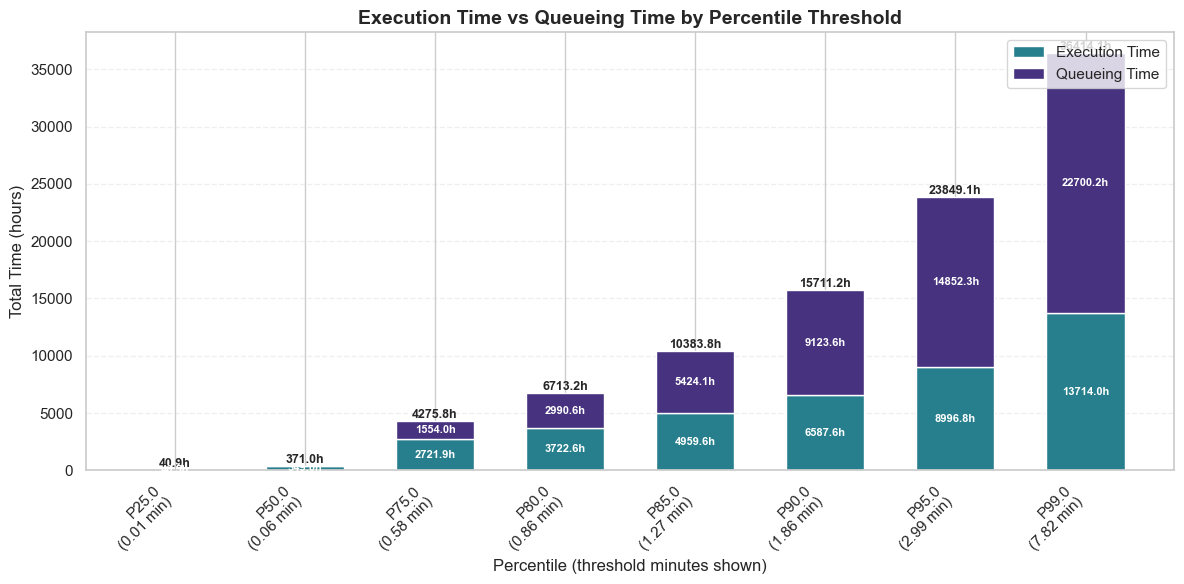

In [3]:
# for each percentile, plot execution time and queueing time as stacked bar plot

def plot_execution_queueing_by_percentile(query_df, time_col='TOTAL_TIME_MIN'):
    """
    Plot execution time and queueing time as stacked bars for each percentile threshold.
    
    For each percentile, aggregates execution and queueing time for all queries
    at or below that percentile threshold.
    
    Parameters:
    -----------
    query_df : pd.DataFrame
        DataFrame with query performance data
    time_col : str
        Column name to use for percentile calculation (default: 'TOTAL_TIME_MIN')
    """
    percentiles = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    
    # Calculate percentile thresholds
    percentile_data = []
    for p in percentiles:
        threshold = query_df[time_col].quantile(p)
        # Filter queries at or below this percentile threshold
        queries_at_or_below = query_df[query_df[time_col] <= threshold]
        
        # Aggregate execution and queueing time for these queries
        total_execution_min = queries_at_or_below['EXECUTION_TIME_MIN'].sum()
        total_queueing_min = queries_at_or_below['QUEUEING_TIME_MIN'].sum()
        query_count = len(queries_at_or_below)
        
        percentile_data.append({
            'percentile': p,
            'percentile_pct': int(p * 100),
            'threshold_min': round(threshold, 2),
            'total_execution_min': total_execution_min,
            'total_queueing_min': total_queueing_min,
            'query_count': query_count
        })
    
    # Create DataFrame
    percentile_df = pd.DataFrame(percentile_data)
    
    # Convert to hours for better readability
    percentile_df['total_execution_hr'] = percentile_df['total_execution_min'] / 60
    percentile_df['total_queueing_hr'] = percentile_df['total_queueing_min'] / 60
    percentile_df['total_time_hr'] = (percentile_df['total_execution_min'] + percentile_df['total_queueing_min']) / 60
    
    # Create x-axis labels
    percentile_df['xtick'] = percentile_df.apply(
        lambda row: f"P{row['percentile_pct']}\n({row['threshold_min']:.2f} min)", 
        axis=1
    )
    
    # Sort by percentile
    percentile_df = percentile_df.sort_values('percentile_pct').reset_index(drop=True)
    
    # Display summary table
    print("Execution and Queueing Time by Percentile:")
    display(percentile_df[['percentile_pct', 'threshold_min', 'query_count', 
                           'total_execution_hr', 'total_queueing_hr', 'total_time_hr']])
    
    # Create stacked bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(percentile_df))
    width = 0.6
    
    # Create stacked bars
    bars1 = ax.bar(
        x_pos,
        percentile_df['total_execution_hr'],
        width,
        label='Execution Time',
        color=ALT_ACCENT
    )
    bars2 = ax.bar(
        x_pos,
        percentile_df['total_queueing_hr'],
        width,
        bottom=percentile_df['total_execution_hr'],
        label='Queueing Time',
        color=ALT_ACCENT_2
    )
    
    # Customize the plot
    ax.set_xlabel('Percentile (threshold minutes shown)', fontsize=12)
    ax.set_ylabel('Total Time (hours)', fontsize=12)
    ax.set_title('Execution Time vs Queueing Time by Percentile Threshold', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(percentile_df['xtick'], rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (exec_hr, queue_hr, total_hr) in enumerate(zip(
        percentile_df['total_execution_hr'],
        percentile_df['total_queueing_hr'],
        percentile_df['total_time_hr']
    )):
        # Label on top of bar showing total
        ax.text(i, total_hr, f'{total_hr:.1f}h',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
        # Label in the middle showing execution time (if large enough)
        if exec_hr > total_hr * 0.1:
            ax.text(i, exec_hr / 2, f'{exec_hr:.1f}h',
                    ha='center', va='center', fontsize=8, color='white', fontweight='bold')
        # Label in queueing section (if large enough)
        if queue_hr > total_hr * 0.1:
            ax.text(i, exec_hr + queue_hr / 2, f'{queue_hr:.1f}h',
                    ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot execution and queueing time by percentile
plot_execution_queueing_by_percentile(query_df, time_col='TOTAL_TIME_MIN')


### Why focus on the 90th percentile?
- **Skewed distribution:** The `runtime_percentiles` table shows the median query finishes in well under a minute, but the 90th/95th percentiles jump several minutes higher, revealing a long right tail.
- **User impact band:** P90 represents the slowest 10% of queries—frequent enough to hit many analysts/BI dashboards, but not dominated by rare incidents (P99).
- **Visualization check:** The histogram confirms a dense cluster of fast queries and a stretched tail. Using P90 captures the segment where waits become painful while keeping attention on common, repeatable delays.
- **Actionable metric:** Improvements that push the tail inward (e.g., better warehouse sizing, spill mitigation) immediately shrink P90, making it a practical KPI for the guild.

### Summary
- Most queries finish quickly, but the 90th percentile jumps several minutes above the median, confirming a long right tail.
- Targeting P90 captures the slowest 10%—frequent enough to affect BI dashboards yet less noisy than extreme incidents.
- The histogram visual backs this up, showing a dense cluster of fast queries and a pronounced tail; shrinking that tail (e.g., via spill mitigation, right-sizing warehouses) is an actionable KPI.


### visualise execution_time and queueing time as staked bar plot

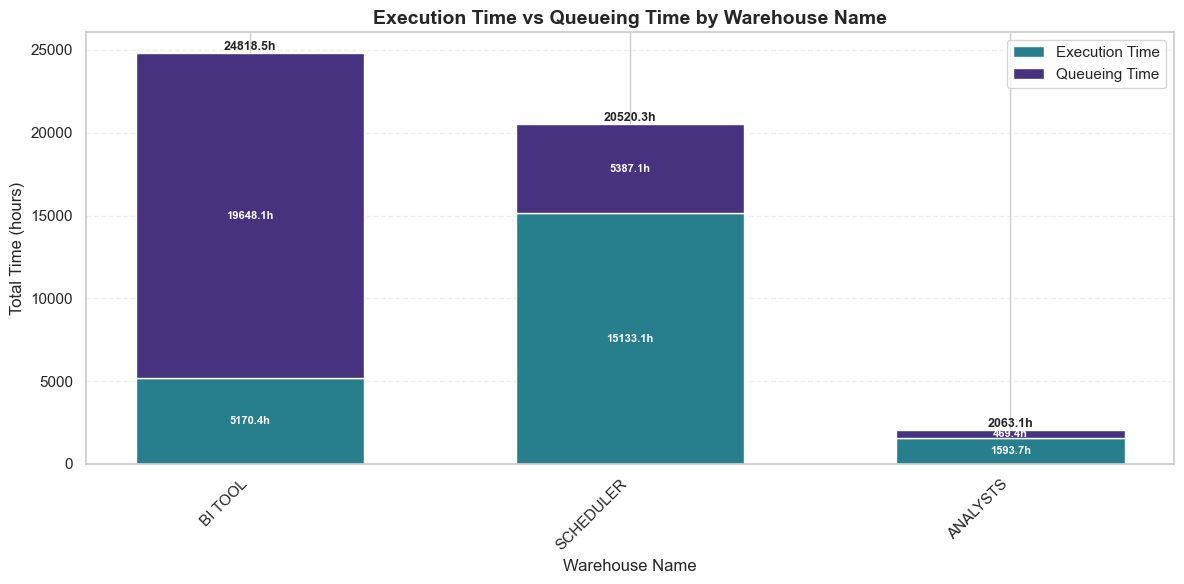


Summary by Warehouse Name:
WAREHOUSE_NAME  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       BI TOOL      2197888         5170.402667       19648.121167   24818.523833
     SCHEDULER      1064854        15133.145167        5387.123500   20520.268667
      ANALYSTS       948482         1593.711333         469.407667    2063.119000


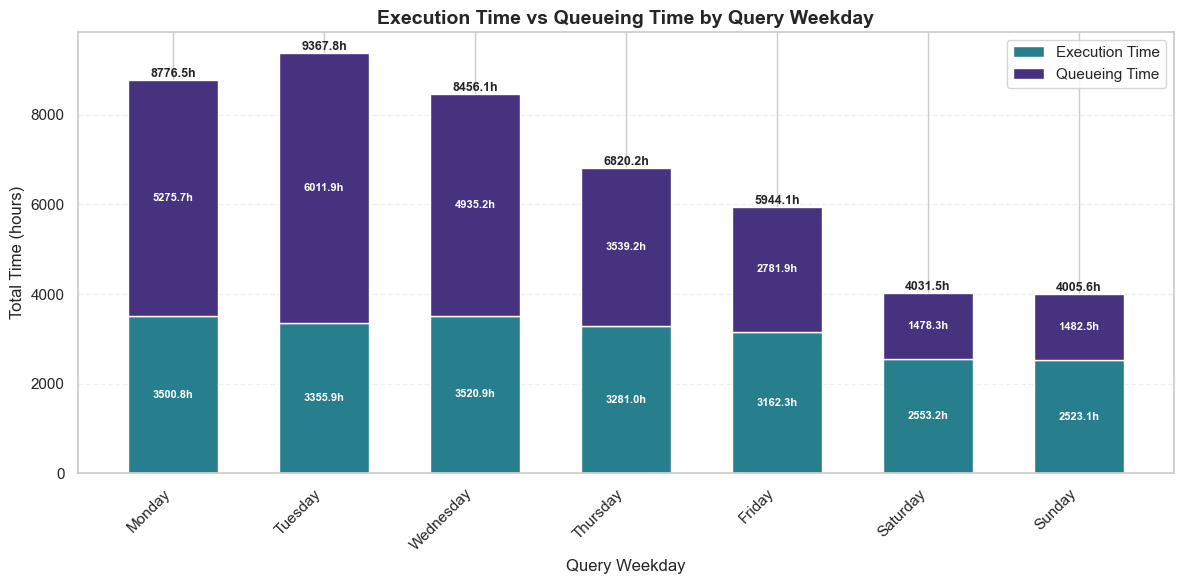


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       757657         3500.813500        5275.734000    8776.547500
      Tuesday       770943         3355.854500        6011.939667    9367.794167
    Wednesday       760709         3520.907667        4935.210167    8456.117833
     Thursday       712930         3281.027000        3539.209500    6820.236500
       Friday       638112         3162.290000        2781.858000    5944.148000
     Saturday       279725         2553.220667        1478.250833    4031.471500
       Sunday       291148         2523.145833        1482.450167    4005.596000


In [4]:
### visualise execution_time and queueing time as staked bar plot

def visualise_execution_and_queueing_time(query_df, main_col):
    # Aggregate execution and queueing time by main_col
    warehouse_times = query_df.groupby(main_col, observed=True).agg(
        total_execution_min=('EXECUTION_TIME_MIN', 'sum'),
        total_queueing_min=('QUEUEING_TIME_MIN', 'sum'),
        query_count=('QUERY_ID', 'count')
    ).reset_index()

    # Sort by total time (execution + queueing) for better visualization
    warehouse_times['total_time_min'] = warehouse_times['total_execution_min'] + warehouse_times['total_queueing_min']
    
    # Apply custom ordering based on main_col
    if main_col == 'QUERY_WEEKDAY':
        # Order by weekday: Monday to Sunday
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        warehouse_times[main_col] = pd.Categorical(warehouse_times[main_col], categories=weekday_order, ordered=True)
        warehouse_times = warehouse_times.sort_values(main_col)
    elif main_col in ['QUERY_HOUR', 'QUERY_HR']:
        # Order by hour: 0-23 (or 1-24 if that's the format)
        warehouse_times = warehouse_times.sort_values(main_col)
    else:
        # Default: sort by total time descending
        warehouse_times = warehouse_times.sort_values('total_time_min', ascending=False)

    # Convert to hours for better readability
    warehouse_times['total_execution_hr'] = warehouse_times['total_execution_min'] / 60
    warehouse_times['total_queueing_hr'] = warehouse_times['total_queueing_min'] / 60
    warehouse_times['total_time_hr'] = warehouse_times['total_time_min'] / 60

    # Create stacked bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x_pos = np.arange(len(warehouse_times))
    width = 0.6

    # Create stacked bars
    bars1 = ax.bar(
        x_pos, 
        warehouse_times['total_execution_hr'], 
        width, 
        label='Execution Time', 
        color=ALT_ACCENT
    )
    bars2 = ax.bar(
        x_pos, 
        warehouse_times['total_queueing_hr'], 
        width, 
        bottom=warehouse_times['total_execution_hr'],
        label='Queueing Time', 
        color=ALT_ACCENT_2
    )

    # Customize the plot
    # Create readable label from main_col
    col_label = main_col.replace('_', ' ').title()
    ax.set_xlabel(col_label, fontsize=12)
    ax.set_ylabel('Total Time (hours)', fontsize=12)
    ax.set_title(f'Execution Time vs Queueing Time by {col_label}', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(warehouse_times[main_col], rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for i, (exec_hr, queue_hr, total_hr) in enumerate(zip(
        warehouse_times['total_execution_hr'],
        warehouse_times['total_queueing_hr'],
        warehouse_times['total_time_hr']
    )):
        # Label on top of bar showing total
        ax.text(i, total_hr, f'{total_hr:.1f}h', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
        # Label in the middle showing execution time
        if exec_hr > total_hr * 0.1:  # Only label if execution time is >10% of total
            ax.text(i, exec_hr / 2, f'{exec_hr:.1f}h', 
                    ha='center', va='center', fontsize=8, color='white', fontweight='bold')
        # Label in queueing section
        if queue_hr > total_hr * 0.1:  # Only label if queueing time is >10% of total
            ax.text(i, exec_hr + queue_hr / 2, f'{queue_hr:.1f}h', 
                    ha='center', va='center', fontsize=8, color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Display summary table
    print(f"\nSummary by {col_label}:")
    print(warehouse_times[[main_col, 'query_count', 'total_execution_hr', 'total_queueing_hr', 'total_time_hr']].to_string(index=False))

visualise_execution_and_queueing_time(query_df, 'WAREHOUSE_NAME')
visualise_execution_and_queueing_time(query_df, 'QUERY_WEEKDAY')


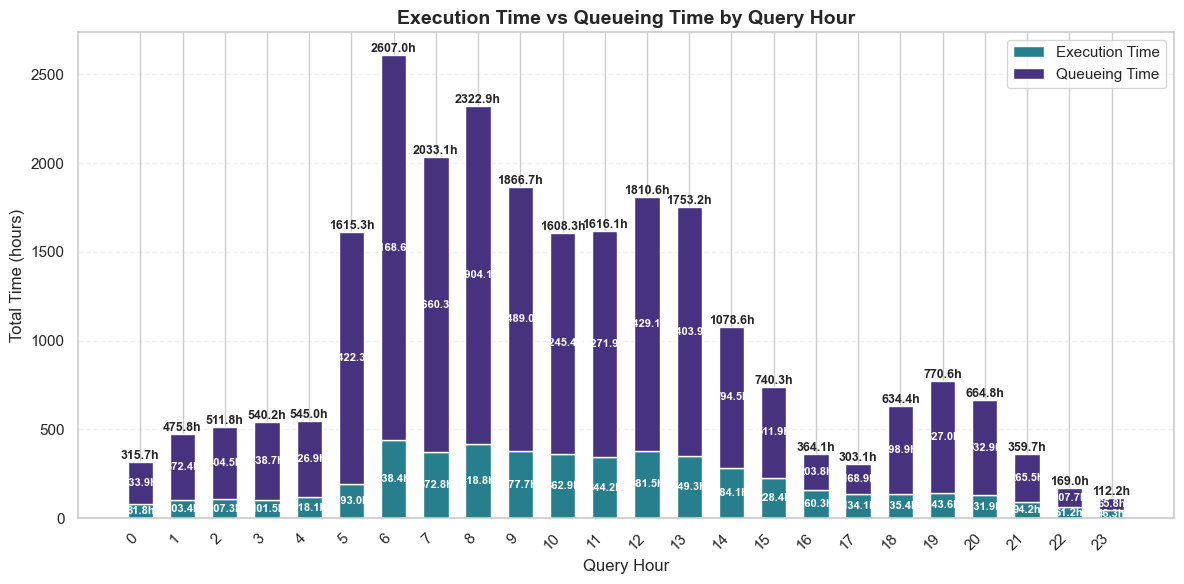


Summary by Query Hour:
 QUERY_HOUR  query_count  total_execution_hr  total_queueing_hr  total_time_hr
          0        23599           81.775000         233.942333     315.717333
          1        26440          103.414500         372.434000     475.848500
          2        30951          107.315667         404.507167     511.822833
          3        28912          101.541167         438.670667     540.211833
          4        39743          118.092333         426.929833     545.022167
          5        61664          193.038000        1422.254667    1615.292667
          6       196929          438.402333        2168.576500    2606.978833
          7       179089          372.786167        1660.285167    2033.071333
          8       190412          418.819667        1904.124000    2322.943667
          9       179896          377.716333        1488.958000    1866.674333
         10       170886          362.902667        1245.408167    1608.310833
         11       164498    

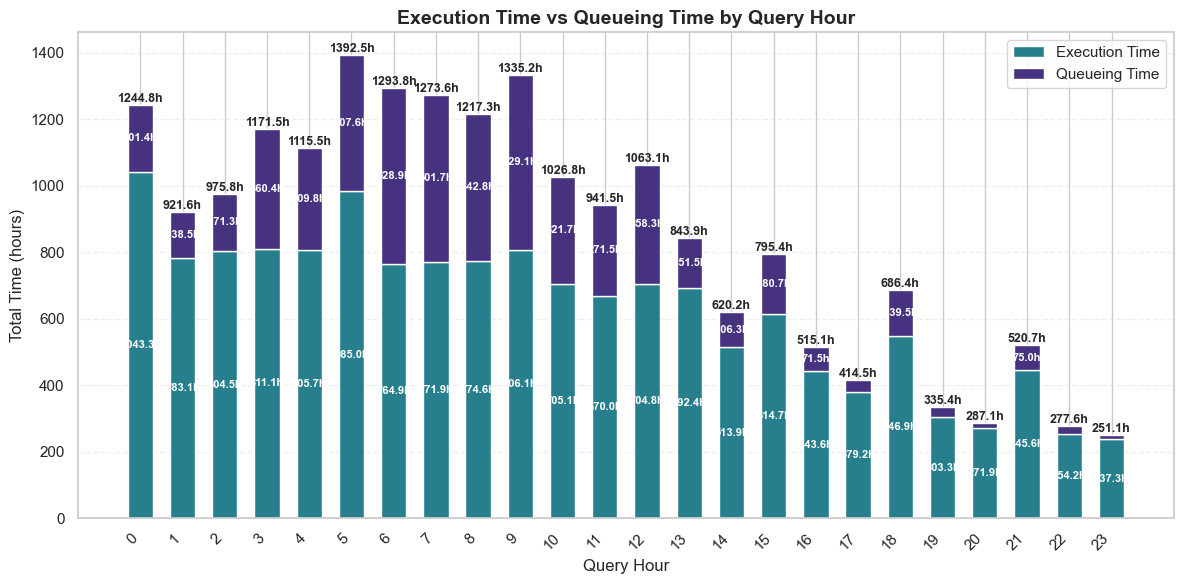


Summary by Query Hour:
 QUERY_HOUR  query_count  total_execution_hr  total_queueing_hr  total_time_hr
          0        69323         1043.332833         201.420667    1244.753500
          1        67802          783.077500         138.547167     921.624667
          2        50287          804.452833         171.332167     975.785000
          3        39384          811.104333         360.353333    1171.457667
          4        40538          805.706833         309.775167    1115.482000
          5        35399          984.992167         407.555833    1392.548000
          6        37431          764.889667         528.947500    1293.837167
          7        53854          771.939500         501.658500    1273.598000
          8        60008          774.551167         442.755500    1217.306667
          9        49436          806.099167         529.082833    1335.182000
         10        52637          705.127333         321.703167    1026.830500
         11        54082    

In [5]:
visualise_execution_and_queueing_time(
    query_df[query_df["WAREHOUSE_NAME"] == "BI TOOL"], "QUERY_HOUR"
)
visualise_execution_and_queueing_time(
    query_df[query_df["WAREHOUSE_NAME"] == "SCHEDULER"], "QUERY_HOUR"
)

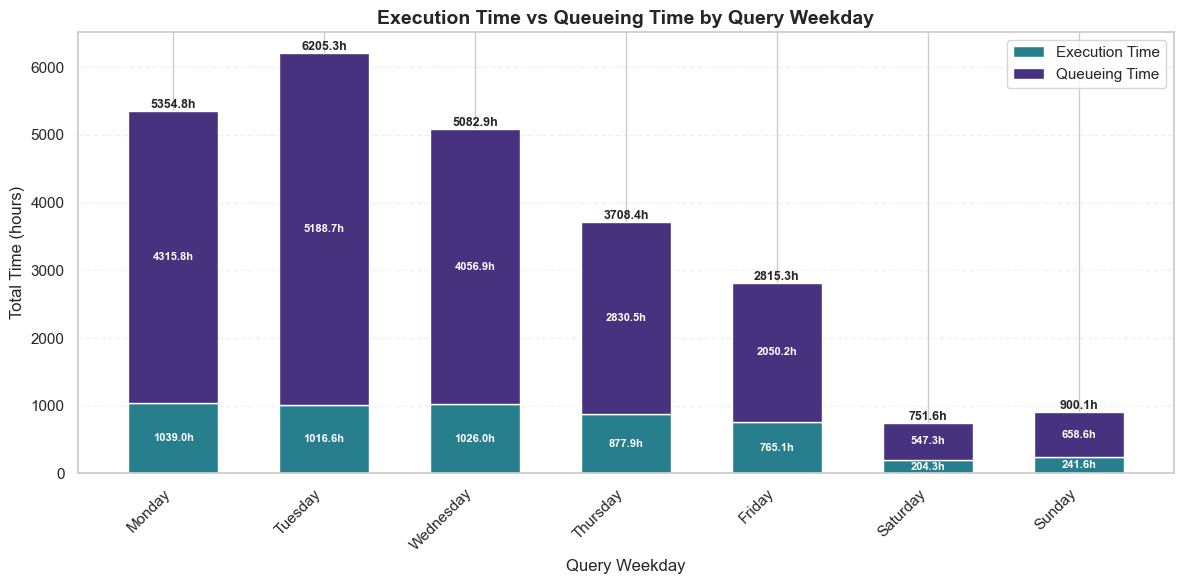


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       454087         1038.980500        4315.826833    5354.807333
      Tuesday       447541         1016.607667        5188.728000    6205.335667
    Wednesday       439102         1025.973667        4056.943000    5082.916667
     Thursday       389287          877.911167        2830.511000    3708.422167
       Friday       336524          765.055667        2050.231167    2815.286833
     Saturday        57095          204.323000         547.322833     751.645833
       Sunday        74252          241.551000         658.558333     900.109333


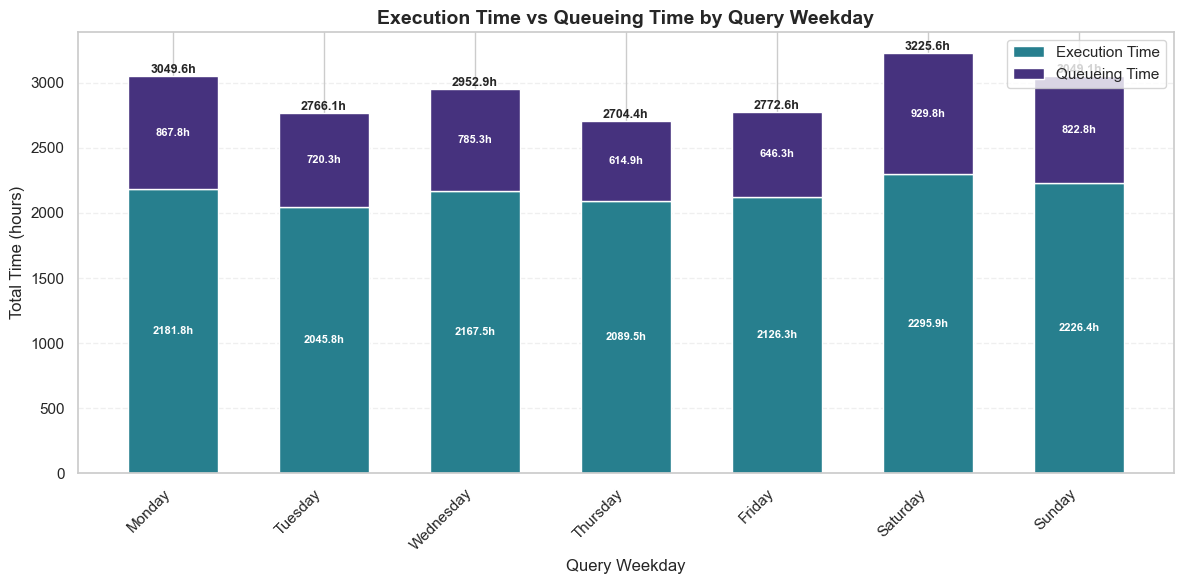


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       150350         2181.829833         867.769167    3049.599000
      Tuesday       151150         2045.801667         720.272500    2766.074167
    Wednesday       164294         2167.513000         785.344333    2952.857333
     Thursday       171021         2089.451000         614.932500    2704.383500
       Friday       162555         2126.309833         646.290167    2772.600000
     Saturday       136498         2295.864000         929.753167    3225.617167
       Sunday       128986         2226.375833         822.761667    3049.137500


In [6]:
visualise_execution_and_queueing_time(query_df[query_df['WAREHOUSE_NAME'] == 'BI TOOL'], 'QUERY_WEEKDAY')
visualise_execution_and_queueing_time(query_df[query_df['WAREHOUSE_NAME'] == 'SCHEDULER'], 'QUERY_WEEKDAY')


In [20]:
from typing import Union, Sequence, Dict, Tuple, Callable

GroupCols = Union[str, Sequence[str]]
NamedAgg = Tuple[str, Union[str, Callable]]

def summarize_query_perf(
    df: pd.DataFrame,
    group_cols: GroupCols,
    extra_aggs: Dict[str, NamedAgg] | None = None,
    sort_by: str | None = 'p90_total_min',
    ascending: bool = False,
    reset_index: bool | None = None,
):
    """Reusable aggregation for query performance metrics in minutes."""
    agg_map: Dict[str, NamedAgg] = {
        'queries': ('QUERY_ID', 'count'),
        'median_total_min': ('TOTAL_TIME_MIN', 'median'),
        'p90_total_min': ('TOTAL_TIME_MIN', lambda x: x.quantile(0.9)),
    }

    if extra_aggs:
        agg_map.update(extra_aggs)

    summary = df.groupby(group_cols).agg(**agg_map)

    if reset_index is None:
        reset_index = isinstance(group_cols, (list, tuple, pd.Index))

    if reset_index:
        summary = summary.reset_index()

    if sort_by:
        summary = summary.sort_values(sort_by, ascending=ascending)

    float_cols = summary.select_dtypes(include='float').columns
    if len(float_cols) > 0:
        summary[float_cols] = summary[float_cols].round(2)

    return summary


In [21]:
# Warehouse level performance overview (minutes)
warehouse_summary = summarize_query_perf(
    query_df,
    group_cols='WAREHOUSE_NAME',
    extra_aggs={
        'queue_time_total_min': ('QUEUEING_TIME_MIN', 'sum'),
        'exec_time_total_min': ('EXECUTION_TIME_MIN', 'sum'),
    },
    sort_by='p90_total_min',
    ascending=False,
    reset_index=True,
)

warehouse_summary.head(10)

/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_80780/3782242296.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)


,WAREHOUSE_NAME,queries,median_total_min,p90_total_min,queue_time_total_min,exec_time_total_min
2,SCHEDULER,1064854,0.04,3.03,323227.41,907988.71
1,BI TOOL,2197888,0.20,1.96,1178887.27,310224.16
0,ANALYSTS,948482,0.00,0.10,28164.46,95622.68


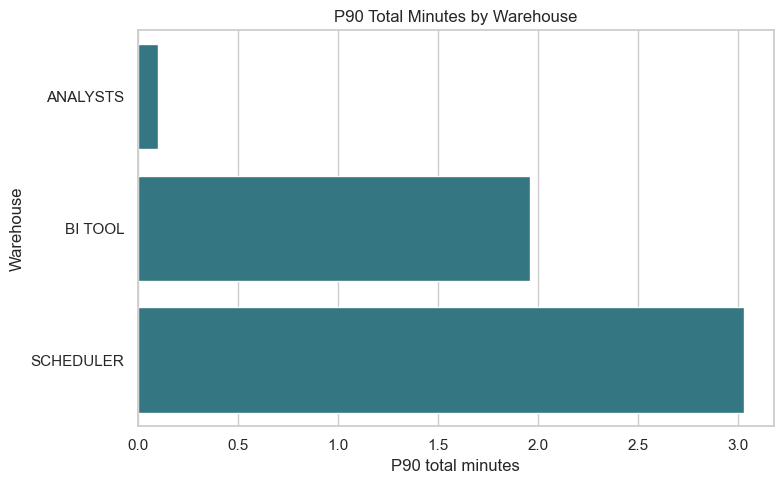

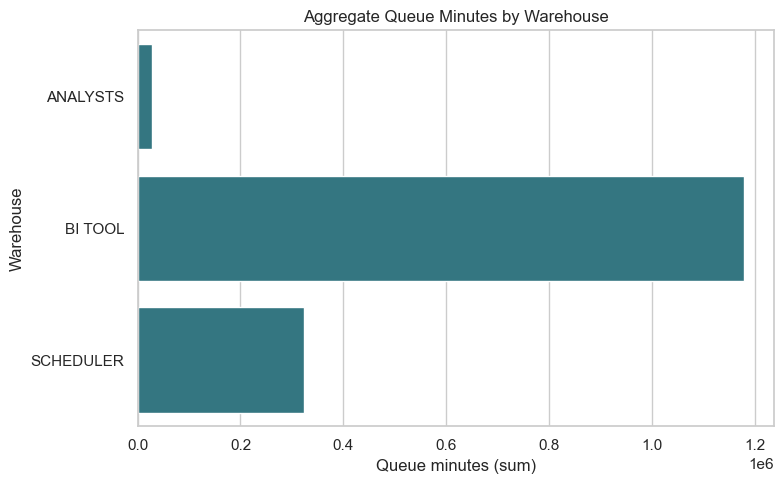

In [ ]:
warehouse_plot_df = warehouse_summary.sort_values("p90_total_min", ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=warehouse_plot_df,
    x="p90_total_min",
    y="WAREHOUSE_NAME",
    color=ALT_ACCENT,
)
plt.title("P90 Total Minutes by Warehouse")
plt.xlabel("P90 total minutes")
plt.ylabel("Warehouse")
plt.tight_layout()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=warehouse_plot_df,
    x="queue_time_total_min",
    y="WAREHOUSE_NAME",
    color=ALT_ACCENT,
)
plt.title("Aggregate Queue Minutes by Warehouse")
plt.xlabel("Queue minutes (sum)")
plt.ylabel("Warehouse")
plt.tight_layout()


### Spill analysis

In [ ]:
# Performance by warehouse size and query type (minutes)
size_querytype_summary = summarize_query_perf(
    query_df[query_df['BYTES_SPILLED_TO_REMOTE'] > 0], # only look at queries that are spilling
    group_cols=['WAREHOUSE_SIZE', 'QUERY_TYPE'],
    extra_aggs={
        'pct_queue_dominant': ('QUEUE_SHARE', lambda x: (x > 0.5).mean()),
    },
    sort_by='p90_total_min',
    ascending=False,
    reset_index=True,
)

size_querytype_summary = size_querytype_summary.drop(columns=['median_queue_share'], errors='ignore')
print(size_querytype_summary.shape)

size_querytype_summary = size_querytype_summary[size_querytype_summary['queries'] > 0]
size_querytype_summary.reset_index(drop=True, inplace=True)
size_querytype_summary

(36, 6)


/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3239457845.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)


,WAREHOUSE_SIZE,QUERY_TYPE,queries,median_total_min,p90_total_min,pct_queue_dominant
0,X-Small,MERGE,2233,9.35,33.72,0.06
1,X-Small,CREATE_TABLE_AS_SELECT,24547,5.21,23.90,0.12
2,Small,MERGE,78,3.25,22.28,0.01
3,Small,CREATE_TABLE_AS_SELECT,1113,3.54,15.61,0.01
4,X-Small,INSERT,7095,5.81,13.86,0.12
5,Small,INSERT,575,2.58,9.17,0.01
6,X-Small,UPDATE,1474,3.87,9.00,0.19
7,X-Small,SELECT,5600,2.94,8.13,0.29
8,X-Small,DELETE,211,3.69,6.41,0.23
9,X-Small,UNLOAD,9,3.24,6.33,0.11


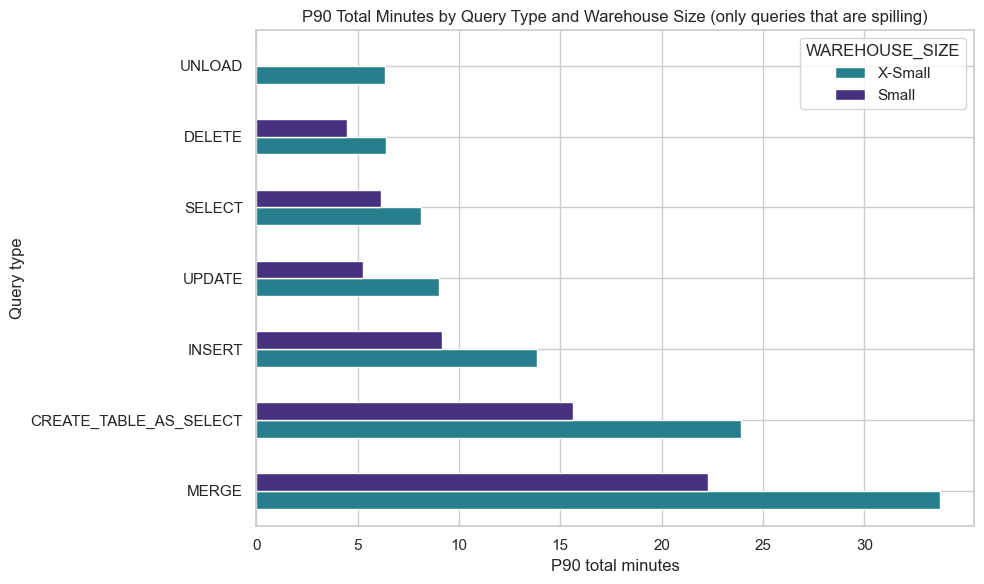

In [ ]:
pivot_df = size_querytype_summary.pivot(
    index="QUERY_TYPE",
    columns="WAREHOUSE_SIZE",
    values="p90_total_min",
)
pivot_df.plot(kind="barh", figsize=(10, 6), color=(ALT_ACCENT, ALT_ACCENT_2))
plt.title("P90 Total Minutes by Query Type and Warehouse Size (only queries that are spilling)")
plt.xlabel("P90 total minutes")
plt.ylabel("Query type")
plt.xticks(np.arange(0, pivot_df.max().max() + 0.5,5))
plt.tight_layout()

In [ ]:
# Remote spill analysis (minutes)
spill_threshold = 0
spill_stats = {
    'pct_queries_with_spill': (query_df['BYTES_SPILLED_TO_REMOTE'] > spill_threshold).mean(),
    'spill_contribution_total_time_min': round(query_df.loc[
        query_df['BYTES_SPILLED_TO_REMOTE'] > spill_threshold, 'TOTAL_TIME_MIN'
    ].median(), 2),
    'spill_vs_nospill_p90_min': {
        'spill': round(query_df.loc[
            query_df['BYTES_SPILLED_TO_REMOTE'] > spill_threshold, 'TOTAL_TIME_MIN'
        ].quantile(0.9), 2),
        'no_spill': round(query_df.loc[
            query_df['BYTES_SPILLED_TO_REMOTE'] <= spill_threshold, 'TOTAL_TIME_MIN'
        ].quantile(0.9), 2),
    },
}
spill_stats


{'pct_queries_with_spill': np.float64(0.010969969776008115),
 'spill_contribution_total_time_min': np.float64(4.48),
 'spill_vs_nospill_p90_min': {'spill': np.float64(18.62),
  'no_spill': np.float64(1.75)}}

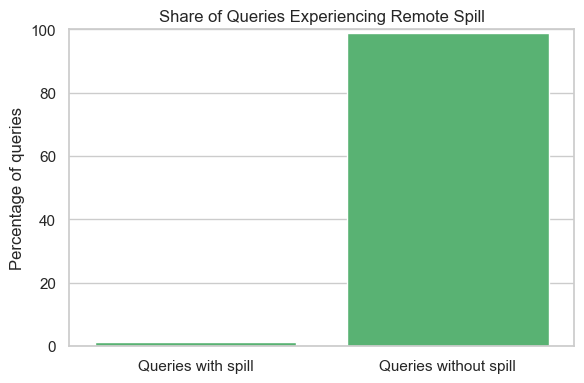

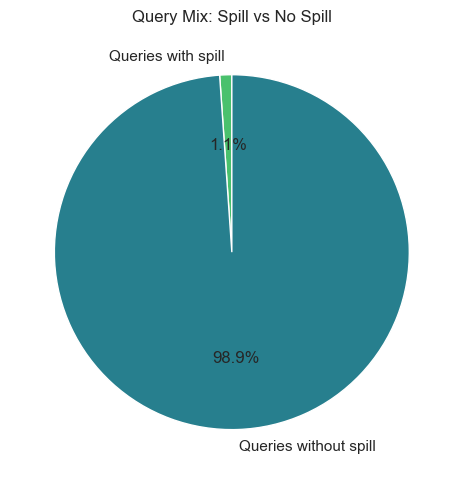

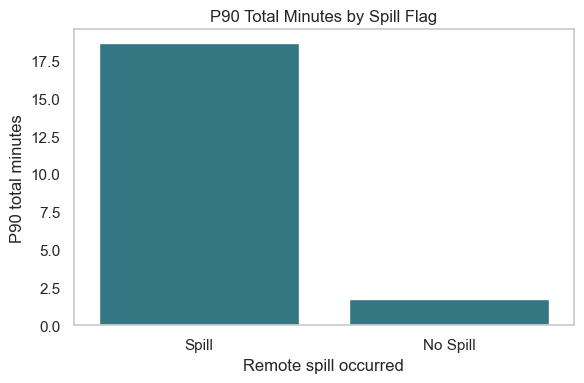

In [ ]:
spill_rate_df = pd.DataFrame([
    {"metric": "Queries with spill", "value": spill_stats['pct_queries_with_spill'] * 100},
    {"metric": "Queries without spill", "value": (1 - spill_stats['pct_queries_with_spill']) * 100},
])
plt.figure(figsize=(6, 4))
sns.barplot(data=spill_rate_df, x="metric", y="value", color=BASE_ACCENT)
plt.title("Share of Queries Experiencing Remote Spill")
plt.ylabel("Percentage of queries")
plt.xlabel("")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.pie(
    spill_rate_df["value"],
    labels=spill_rate_df["metric"],
    autopct="%1.1f%%",
    startangle=90,
    colors=[BASE_ACCENT, ALT_ACCENT],
)
plt.title("Query Mix: Spill vs No Spill")
plt.tight_layout()
plt.show()

spill_p90_df = pd.DataFrame([
    {"spill_flag": "Spill", "p90_total_min": spill_stats['spill_vs_nospill_p90_min']['spill']},
    {"spill_flag": "No Spill", "p90_total_min": spill_stats['spill_vs_nospill_p90_min']['no_spill']},
])
plt.figure(figsize=(6, 4))
sns.barplot(data=spill_p90_df, x="spill_flag", y="p90_total_min", color=ALT_ACCENT)
plt.title("P90 Total Minutes by Spill Flag")
plt.xlabel("Remote spill occurred")
plt.ylabel("P90 total minutes")
plt.tight_layout()
plt.grid(False)
plt.show()


In [ ]:
# Weekday patterns (minutes)
if 'WEEKDAY' not in query_df.columns:
    query_df = query_df.assign(
        QUERY_DATE=query_df['QUERY_START_TIME'].dt.date,
        QUERY_HOUR=query_df['QUERY_START_TIME'].dt.hour,
        WEEKDAY=query_df['QUERY_START_TIME'].dt.day_name(),
    )

weekday_summary = summarize_query_perf(
    query_df,
    group_cols='WEEKDAY',
    sort_by=None,
    ascending=True,
    reset_index=False,
).reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

weekday_summary


,queries,median_total_min,p90_total_min,median_queue_share
WEEKDAY,,,,
Monday,757657,0.08,1.92,0.0
Tuesday,770943,0.08,2.12,0.0
Wednesday,760709,0.07,1.87,0.0
Thursday,712930,0.05,1.55,0.0
Friday,638112,0.05,1.43,0.0
Saturday,279725,0.03,2.23,0.0
Sunday,291148,0.03,2.09,0.0


In [ ]:
# Human vs automated workloads (minutes)
human_summary = summarize_query_perf(
    query_df,
    group_cols='HUMAN_USER',
    sort_by='p90_total_min',
    ascending=False,
    reset_index=True,
)

human_summary


,HUMAN_USER,queries,median_total_min,p90_total_min,median_queue_share
0,False,3893104,0.07,1.95,0.0
1,True,318120,0.01,0.35,0.0


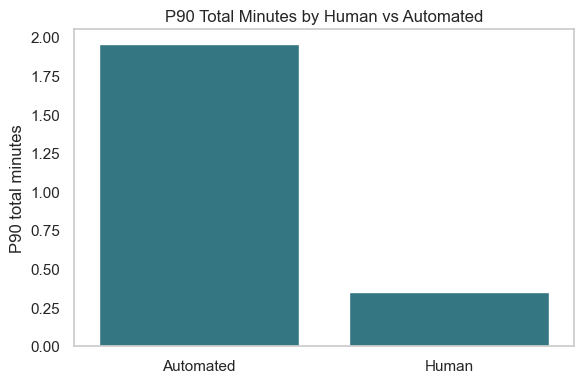

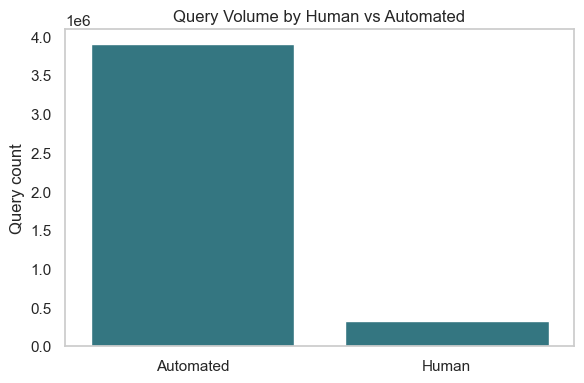

In [ ]:
human_plot_df = human_summary.assign(HUMAN_USER=human_summary['HUMAN_USER'].map({True: 'Human', False: 'Automated'}))
plt.figure(figsize=(6, 4))
sns.barplot(
    data=human_plot_df,
    x="HUMAN_USER",
    y="p90_total_min",
    color=ALT_ACCENT,
)
plt.title("P90 Total Minutes by Human vs Automated")
plt.xlabel("")
plt.ylabel("P90 total minutes")
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(
    data=human_plot_df,
    x="HUMAN_USER",
    y="queries",
    color=ALT_ACCENT,
)
plt.title("Query Volume by Human vs Automated")
plt.xlabel("")
plt.ylabel("Query count")
plt.grid(False)
plt.tight_layout()
plt.show()


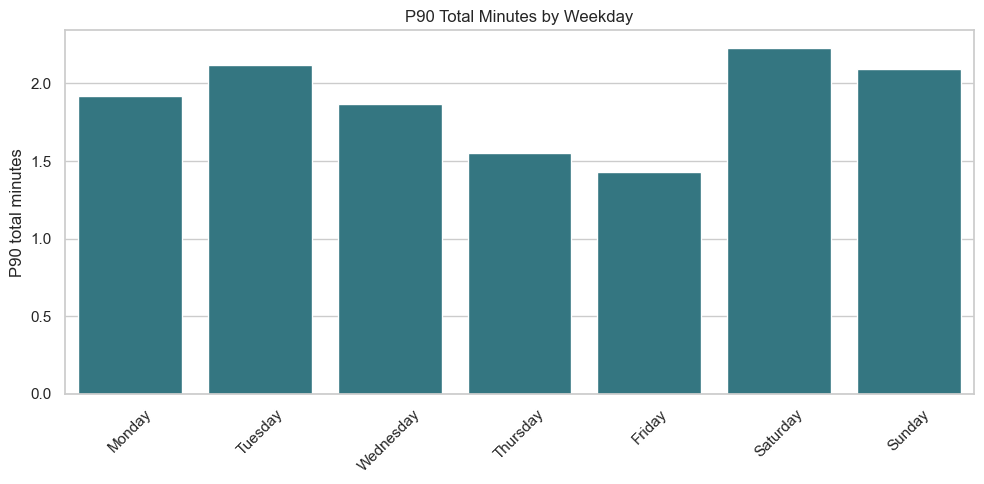

/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3239457845.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)
/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3066366033.py:32: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(


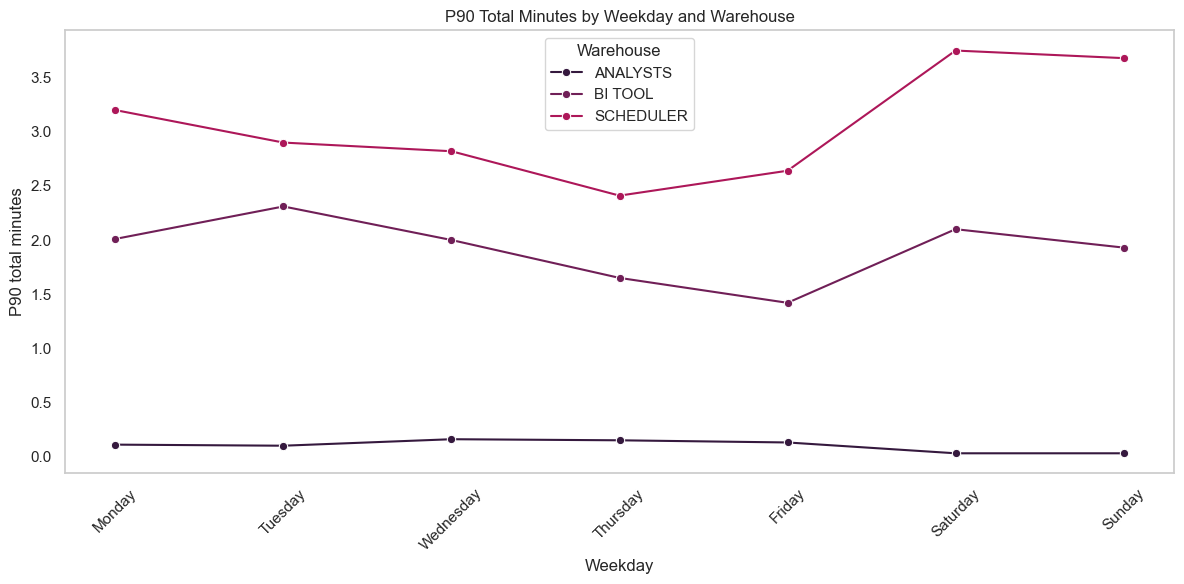

In [ ]:
weekday_plot_df = weekday_summary.reset_index().rename(columns={"index": "WEEKDAY"})
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_plot_df["WEEKDAY"] = pd.Categorical(weekday_plot_df["WEEKDAY"], categories=weekday_order, ordered=True)
weekday_plot_df = weekday_plot_df.sort_values("WEEKDAY")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=weekday_plot_df,
    x="WEEKDAY",
    y="p90_total_min",
    color=ALT_ACCENT,
)
plt.title("P90 Total Minutes by Weekday")
plt.xlabel("")
plt.ylabel("P90 total minutes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

weekday_wh_summary = summarize_query_perf(
    query_df,
    group_cols=["WAREHOUSE_NAME", "WEEKDAY"],
    sort_by=None,
    ascending=True,
    reset_index=True,
)
weekday_wh_summary = weekday_wh_summary.drop(columns=["median_queue_share"], errors="ignore")
weekday_wh_summary["WEEKDAY"] = pd.Categorical(weekday_wh_summary["WEEKDAY"], categories=weekday_order, ordered=True)
weekday_wh_summary = weekday_wh_summary.sort_values(["WAREHOUSE_NAME", "WEEKDAY"])

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekday_wh_summary,
    x="WEEKDAY",
    y="p90_total_min",
    hue="WAREHOUSE_NAME",
    palette=LINE_PALETTE,
    marker="o",
    errorbar=None,
)
plt.title("P90 Total Minutes by Weekday and Warehouse")
plt.xlabel("Weekday")
plt.ylabel("P90 total minutes")
plt.xticks(rotation=45)
plt.legend(title="Warehouse")
plt.tight_layout()
plt.grid(False)
plt.show()



In [ ]:
print(objects_df.SCHEMA_NAME.nunique(), objects_df.SCHEMA_INDEX.nunique())
objects_df.groupby(['SCHEMA_NAME','SCHEMA_INDEX']).agg(
    QUERY_ID=('QUERY_ID', 'nunique')
).sort_values('QUERY_ID', ascending=False).head(10)


223 67


QUERY_ID
SCHEMA_NAME SCHEMA_INDEX          
REPORTS     0              2440632
            1              1532545
            2               859749
FX          0               375336
REPORTS     3               331878
FX          1               292287
            2               248739
DDCASE      0               191826
REPORTS     4               185710
FX          3               178332

/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3239457845.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)


,SCHEMA_BUCKET,queries,median_total_min,p90_total_min,median_queue_share,queue_time_total_min,volume_pct,queue_time_pct
2,4-5,62598,1.18,7.98,0.1,54417.62,1.5,3.6
3,6-10,6726,2.04,6.27,0.0,2089.64,0.2,0.1
1,2-3,941060,0.44,3.12,0.0,570799.72,22.3,37.3
0,1,3198766,0.03,1.30,0.0,902971.40,76.0,59.0
4,11+,2074,0.06,0.11,0.0,0.76,0.0,0.0


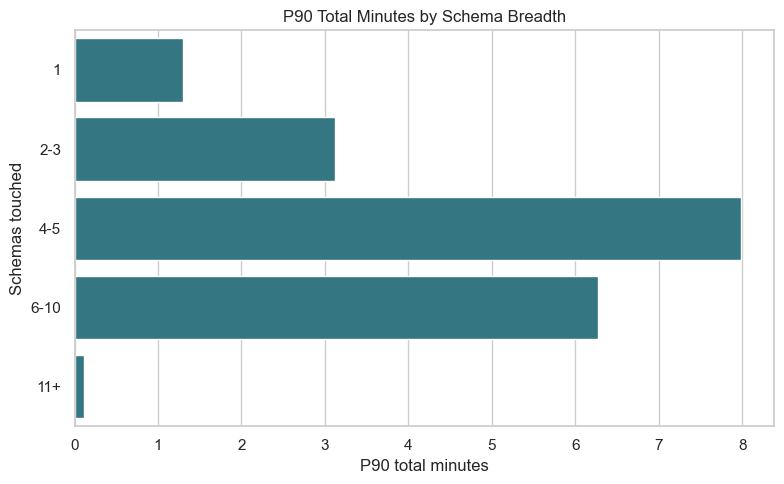

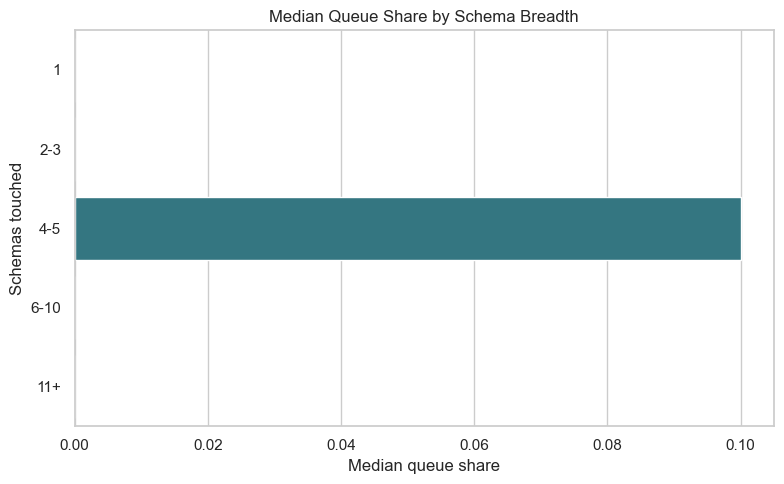

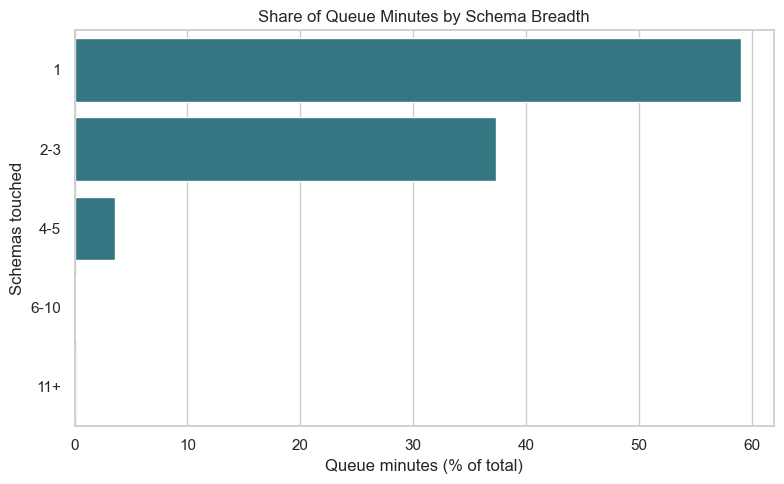

In [ ]:
# Impact of schema breadth on performance (minutes)
schema_touch_summary = summarize_query_perf(
    query_df,
    group_cols=pd.cut(
        query_df['SCHEMA_TOUCHES'],
        bins=[0, 1, 3, 5, 10, query_df['SCHEMA_TOUCHES'].max()],
        labels=["1", "2-3", "4-5", "6-10", "11+"],
        right=True,
    ),
    extra_aggs={
        'queue_time_total_min': ('QUEUEING_TIME_MIN', 'sum'),
        'median_queue_share': ('QUEUE_SHARE', 'median'),
    },
    sort_by='p90_total_min',
    ascending=False,
    reset_index=True,
)

schema_touch_summary = schema_touch_summary.rename(columns={'SCHEMA_TOUCHES': 'SCHEMA_BUCKET'})
schema_touch_summary['volume_pct'] = (schema_touch_summary['queries'] / schema_touch_summary['queries'].sum() * 100).round(1)
schema_touch_summary['queue_time_pct'] = (
    schema_touch_summary['queue_time_total_min'] / schema_touch_summary['queue_time_total_min'].sum() * 100
).round(1)

display(schema_touch_summary)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=schema_touch_summary,
    x="p90_total_min",
    y="SCHEMA_BUCKET",
    color=ALT_ACCENT,
)
plt.title("P90 Total Minutes by Schema Breadth")
plt.xlabel("P90 total minutes")
plt.ylabel("Schemas touched")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=schema_touch_summary,
    x="median_queue_share",
    y="SCHEMA_BUCKET",
    color=ALT_ACCENT,
)
plt.title("Median Queue Share by Schema Breadth")
plt.xlabel("Median queue share")
plt.ylabel("Schemas touched")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=schema_touch_summary,
    x="queue_time_pct",
    y="SCHEMA_BUCKET",
    color=ALT_ACCENT,
)
plt.title("Share of Queue Minutes by Schema Breadth")
plt.xlabel("Queue minutes (% of total)")
plt.ylabel("Schemas touched")
plt.tight_layout()
plt.show()


In [ ]:
top_p90 = schema_touch_summary.sort_values('p90_total_min', ascending=False).iloc[0]
queue_heavy = schema_touch_summary.sort_values('queue_time_pct', ascending=False).iloc[0]
print(
    f"Queries touching {top_p90['SCHEMA_BUCKET']} schemas have the highest P90 runtime at {top_p90['p90_total_min']} min."
)
print(
    f"That bucket also drives {queue_heavy['queue_time_pct']}% of queue minutes while representing {queue_heavy['volume_pct']}% of queries."
)


Queries touching 4-5 schemas have the highest P90 runtime at 7.98 min.
That bucket also drives 59.0% of queue minutes while representing 76.0% of queries.


In [ ]:
# Identify warehouses driving queueing time (minutes)
warehouse_queue_rank = summarize_query_perf(
    query_df,
    group_cols='WAREHOUSE_NAME',
    extra_aggs={
        'queue_time_total_min': ('QUEUEING_TIME_MIN', 'sum'),
        'exec_time_total_min': ('EXECUTION_TIME_MIN', 'sum'),
    },
    sort_by='queue_time_total_min',
    ascending=False,
    reset_index=True,
)

warehouse_queue_rank.head(10)


/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3239457845.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)


,WAREHOUSE_NAME,queries,median_total_min,p90_total_min,median_queue_share,queue_time_total_min,exec_time_total_min
1,BI TOOL,2197888,0.20,1.96,0.26,1178887.27,310224.16
2,SCHEDULER,1064854,0.04,3.03,0.00,323227.41,907988.71
0,ANALYSTS,948482,0.00,0.10,0.00,28164.46,95622.68


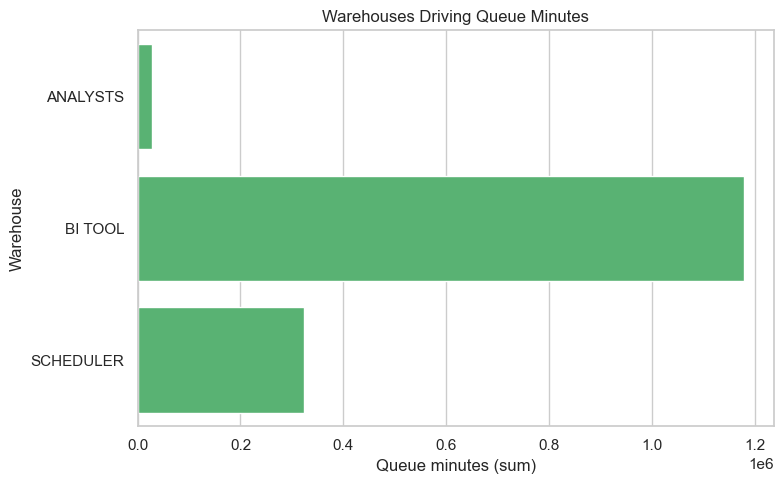

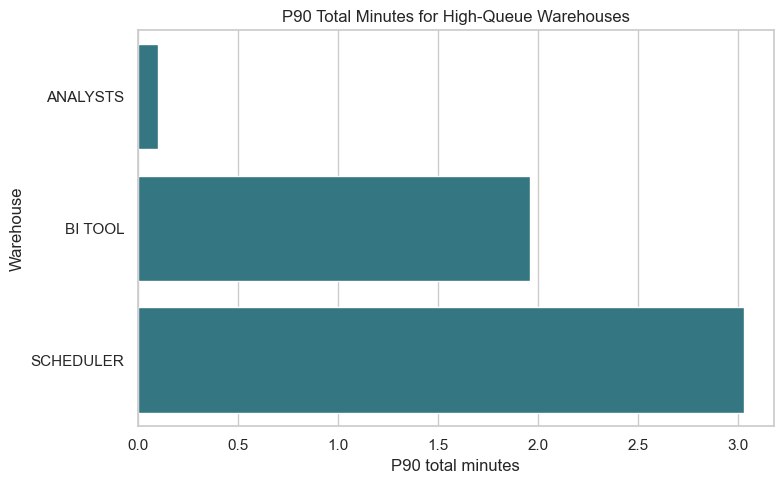

In [ ]:
warehouse_queue_plot_df = warehouse_queue_rank.sort_values("queue_time_total_min", ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=warehouse_queue_plot_df,
    x="queue_time_total_min",
    y="WAREHOUSE_NAME",
    color=BASE_ACCENT,
)
plt.title("Warehouses Driving Queue Minutes")
plt.xlabel("Queue minutes (sum)")
plt.ylabel("Warehouse")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=warehouse_queue_plot_df,
    x="p90_total_min",
    y="WAREHOUSE_NAME",
    color=ALT_ACCENT,
)
plt.title("P90 Total Minutes for High-Queue Warehouses")
plt.xlabel("P90 total minutes")
plt.ylabel("Warehouse")
plt.tight_layout()
plt.show()


/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/3239457845.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_cols).agg(**agg_map)


,WAREHOUSE_NAME,QUERY_HOUR,queries,median_total_min,p90_total_min,median_queue_share,queue_time_total_min,exec_time_total_min
0,ANALYSTS,0,9271,0.02,0.12,0.00,17.75,907.06
48,SCHEDULER,0,69323,0.11,2.50,0.00,12085.24,62599.97
24,BI TOOL,0,23599,0.34,2.14,0.38,14036.54,4906.50
1,ANALYSTS,1,9104,0.02,0.11,0.00,23.21,931.00
49,SCHEDULER,1,67802,0.06,1.90,0.00,8312.83,46984.65
25,BI TOOL,1,26440,0.40,2.98,0.48,22346.04,6204.87
2,ANALYSTS,2,190503,0.00,0.00,0.00,19.16,991.45
50,SCHEDULER,2,50287,0.06,2.80,0.00,10279.93,48267.17
26,BI TOOL,2,30951,0.37,2.78,0.46,24270.43,6438.94
51,SCHEDULER,3,39384,0.13,4.79,0.00,21621.20,48666.26


/var/folders/l7/x3prn1_x3hb6nk9gkfb45jpw0000gn/T/ipykernel_67795/2755601219.py:17: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(


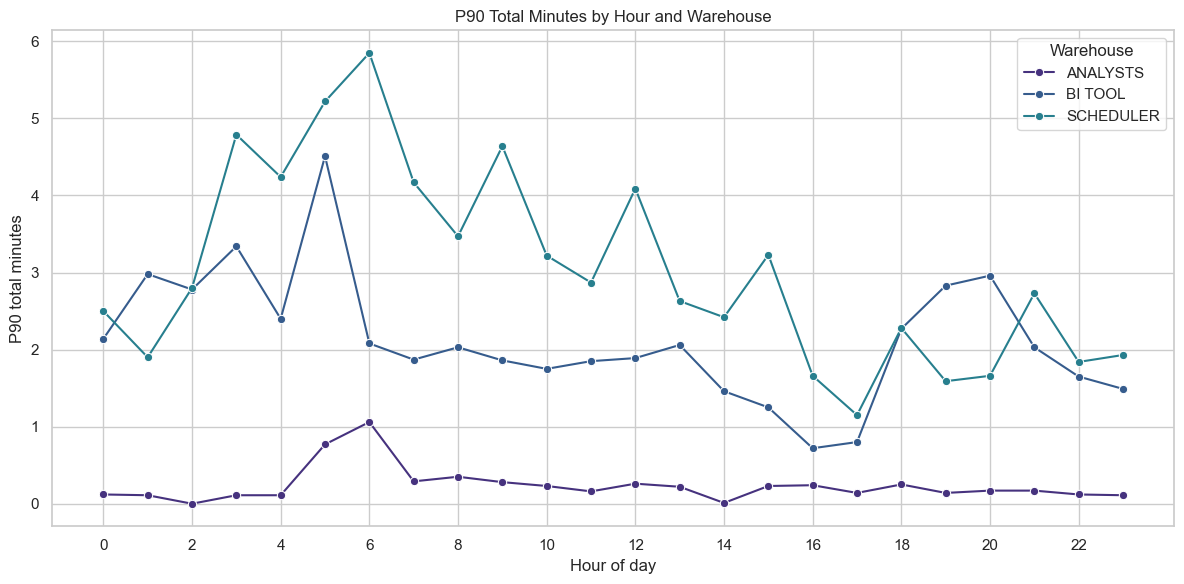

In [ ]:
# Hourly queueing load (minutes)
hourly_queue = summarize_query_perf(
    query_df,
    group_cols=['WAREHOUSE_NAME', 'QUERY_HOUR'],
    extra_aggs={
        'queue_time_total_min': ('QUEUEING_TIME_MIN', 'sum'),
        'exec_time_total_min': ('EXECUTION_TIME_MIN', 'sum'),
    },
    sort_by='QUERY_HOUR',
    ascending=True,
    reset_index=True,
)

display(hourly_queue.head(30))

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_queue,
    x="QUERY_HOUR",
    y="p90_total_min",
    hue="WAREHOUSE_NAME",
    palette=BASE_PALETTE,
    marker="o",
)
plt.title("P90 Total Minutes by Hour and Warehouse")
plt.xlabel("Hour of day")
plt.ylabel("P90 total minutes")
plt.xticks(range(0, 24, 2))
plt.legend(title="Warehouse")
plt.tight_layout()
plt.show()


In [ ]:
# Time of day patterns (minutes)
query_df = query_df.assign(
    QUERY_DATE=query_df['QUERY_START_TIME'].dt.date,
    QUERY_HOUR=query_df['QUERY_START_TIME'].dt.hour,
    WEEKDAY=query_df['QUERY_START_TIME'].dt.day_name(),
)

hourly_summary = summarize_query_perf(
    query_df,
    group_cols='QUERY_HOUR',
    sort_by='QUERY_HOUR',
    ascending=True,
    reset_index=True,
)

hourly_summary.head(10)


,QUERY_HOUR,queries,median_total_min,p90_total_min,median_queue_share
0,0,102193,0.12,2.17,0.00
1,1,103346,0.09,2.19,0.00
2,2,271741,0.00,0.60,0.00
3,3,79178,0.12,3.68,0.00
4,4,91668,0.12,2.86,0.00
5,5,114402,0.29,4.32,0.00
6,6,258476,0.26,2.26,0.38
7,7,264788,0.11,2.02,0.00
8,8,283765,0.12,2.09,0.00
9,9,266556,0.11,2.05,0.00
